# **Exploratory Data Analysis of Logistics Data from Company Loggi**

## 1\. Context

**Exploratory Data Analysis of Logistics Data from Company Loggi.**

A Loggi, a Brazilian technology startup, is classified as a unicorn company. Its focus lies within the logistics sector. The company commenced its operations in 2013, initially catering to document delivery, and expanded its services to the e-commerce sector two years later. Starting from 2017, Loggi further diversified its operations by venturing into the food delivery segment.

Loggi can be categorized as a last-mile logistics company, specializing in providing transportation and delivery services directly to end consumers or businesses at their final location, typically in urban or suburban areas. The "last mile" refers to the final stage of the supply chain, where products are delivered from the distribution center or warehouse to the customer's ultimate destination. These companies play a crucial role in the efficient and timely delivery of products to customers, especially in a rapidly growing e-commerce environment, where fast and reliable delivery has become a key factor in business success.

The Loggi Benchmark for Urban Deliveries (BUD) is a resource available on GitHub (link) that offers data and codes related to common challenges faced by logistics companies. It addresses issues such as optimizing delivery routes and efficiently allocating deliveries in vehicles with limited capacity. These data are derived from public sources, including IBGE and IPEA, and reflect the daily challenges that the Loggi startup faces, particularly in terms of its ongoing expansion and scaling efforts.

Furthermore, some tasks are presented from Loggi's own GitHub repository.

Task 1 - Last-Mile Capacitated Vehicle Routing Problem: This task involves minimizing travel distance in a classic Capacitated Vehicle Routing Problem (CVRP). While solving such large CVRPs with complete information is often impractical, these solutions serve as good targets for Task 2.

Task 2 - Last-Mile Incremental Capacitated Vehicle Routing Problem: This task is considered a specific case of Stochastic and Dynamic Capacitated Vehicle Routing Problems (SD-CVRP). The objective is to sort deliveries into routes as they arrive, using only historical information and previously routed deliveries from the same instance. No recombination is allowed after assignment. From an operational standpoint, this solution class is more powerful as it doesn't require full information before starting routing, allowing hub operators to route deliveries as they arrive.

Task 3 - End-to-end last-mile problem: This task extends from Task 1.2 but without fixed dispatch locations. Therefore, the solution considers locations and allocation of requests to dispatch locations, which should be consistent across multiple instances. This can be viewed as an end-to-end optimization of last-mile delivery operations.

Based on these tasks, we will explore the data provided by Loggi.


## 2\. Pacotes e bibliotecas

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import geopy
from geopy.geocoders import Nominatim
import geopandas
from geopy.extra.rate_limiter import RateLimiter

!pip3 install geopandas;

## 3\. Data exploration

  The raw data provided by the company Loggi comprises a JSON file that includes a list of delivery occurrences, where each occurrence represents a set of deliveries assigned to vehicles associated with the regional distribution center. An illustrative example is as follows:

```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...


Where:

- **name**: A `string` containing the unique name of the instance.
- **region**: A `string` containing the unique name of the hub's region.
- **origin**: A `dict` dictionary that includes the latitude and longitude of the hub's region.
- **vehicle_capacity**: An `int` integer representing the sum of the load capacity of the hub's vehicles.
- **deliveries**: A `list` list of `dict` dictionaries describing the deliveries to be made.

Considering that:


id: a string with the unique ID of the delivery;
point: a dict with the latitude and longitude of the delivery;
size: an int with the size or load that the delivery occupies in the vehicle.

To begin the analysis, we start by processing the raw data and construct the Pandas DataFrame deliveries_df through operations such as flattening and expanding columns:

In [2]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

 - **Column**: origin

We can observe that the origin column contains nested data in the JSON structure. Let's perform normalization on this column using an operation called flatten or flattening, which will convert each key in the JSON into a new column:

 - **Column**: deliveries

The deliveries column, on the other hand, contains a list of nested data in the JSON structure. Let's normalize this column using an operation called explode, which will transform each element of the list into a row. Later, we will flatten the results into separate columns.

## 4\. Data Manipulation

In [3]:
# dado bruto em um dict

with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# dado bruto no pandas

deliveries_df = pd.DataFrame(data)

# coluna origin

hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

# coluna deliveries

deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [4]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [5]:
deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

In [6]:
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [7]:
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


We can check which columns have missing data.

In [8]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

### **4.1 Data Enrichment**

 **4.2 Reverse Geocoding**

Geocoding is the process that converts location information, such as addresses or place names, into their corresponding geographic coordinates, namely latitude and longitude. On the other hand, reverse geocoding performs the inverse process, converting geographic coordinates of a location into their corresponding textual descriptions.

In [9]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [10]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 46410411,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.10000999999999993,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "stat

In [11]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [12]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [13]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [14]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-14-e7ffd1c368d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-14-e7ffd1c368d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-14-e7ffd1c368d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [16]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [17]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


 - **Reverse Geocoding of the delivery**

Although the hub contains only 3 distinct geolocations, the total number of deliveries is 636,149. This means that, considering the limitation of one query per second on the Nominatim server, it would take approximately 7 days to query all deliveries. However, for heavy loads like this, the software offers the option of a local installation (on your own machine), which can be used without any restrictions, making it unfeasible to solve the exercise. To work around this situation, a CSV file has been provided to continue the exercise.

In [18]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [19]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [20]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


## **5\. Data quality**

Now we can see the data consistency after manipulation as we can see the schema, there are no missing values.

In [21]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 79.2+ MB


In [22]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [23]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [24]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [25]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

In [26]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

## 6\. Data Visualization

 - **Map of Deliveries**

To create the visualization, we will create the DataFrame geo_deliveries_df from the DataFrame deliveries_df. With this, a new column called geometry will be created.


The Python package used will be GeoPandas to visualize the coordinates of the hubs and deliveries on the map of the Federal District, segmented by the hubs' regions. The package adds geospatial functionalities to the Python Pandas package.

 - **Map of the Federal District**


The IBGE provides the following map data through the following link, and with this link, we will create the DataFrame 'mapa'. Pay attention to the 'geometry' column.







In [27]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [28]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


 - **Hubs Maps**


Let's create the DataFrame geo_hub_df from the DataFrame deliveries_df. Note the new column 'geometry'.

In [29]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


 - **Deliveries Maps**

Let's create the DataFrame geo_deliveries_df from the DataFrame deliveries_df. Note the new column geometry.

In [30]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


 - **Visualization**

<ipython-input-31-44de6b1fad48>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


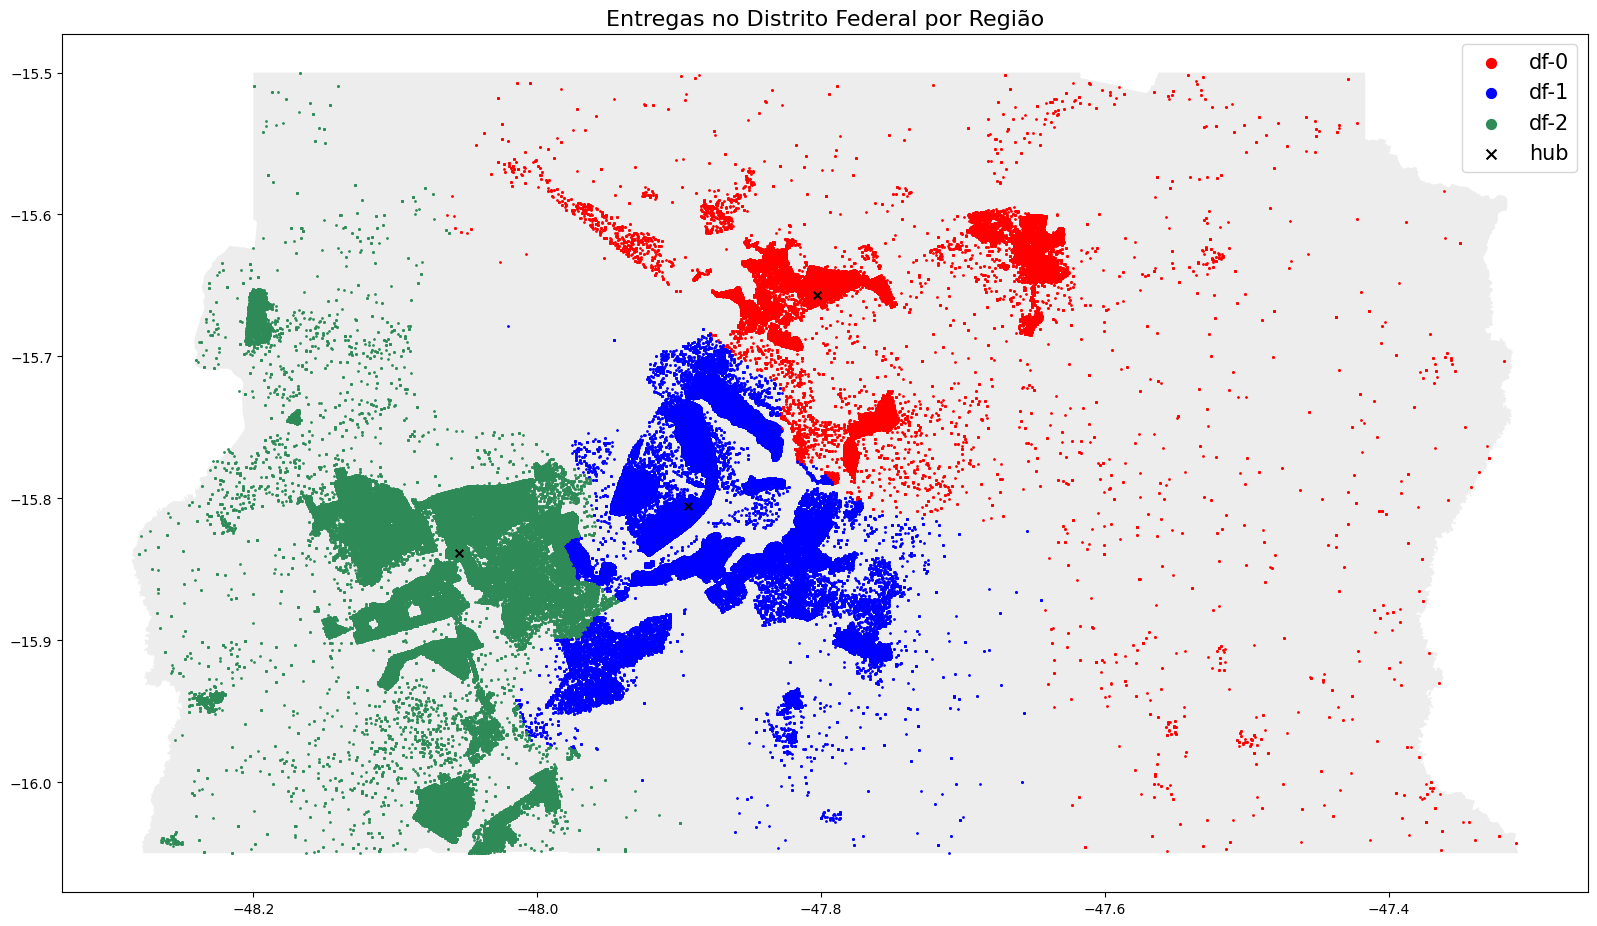

In [31]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

In [33]:
# Filtrar as linhas onde 'region' é igual a 'df-0'
df_df0 = deliveries_df[deliveries_df['region'] == 'df-0']

# Resetar o índice do novo DataFrame, se necessário
df_df0.reset_index(drop=True, inplace=True)

# Exibir as primeiras linhas do novo DataFrame
df_df0.head()


,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-0-df-7,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,3,-47.754844,-15.651816,Itapoã,Del Lago II
1,cvrp-0-df-7,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,4,-47.757320,-15.648223,Itapoã,Fazendinha
2,cvrp-0-df-7,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,5,-47.756113,-15.652011,Itapoã,Del Lago II
3,cvrp-0-df-7,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,3,-47.758499,-15.653910,Itapoã,Condomínio Mansões Entrelagos
4,cvrp-0-df-7,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,3,-47.755965,-15.653289,Itapoã,Condomínio Mansões Entrelagos


<ipython-input-34-a1cb7f508bd6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_df0['distance_hub_delivery'] = distances_hub_delivery


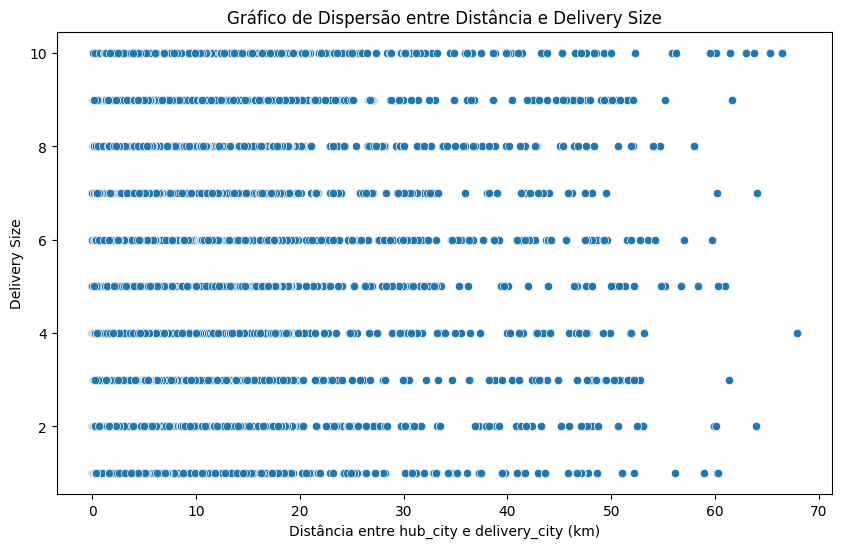

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Calcular a distância entre 'hub_city' e 'delivery_city' para cada linha
distances_hub_delivery = []

for index, row in df_df0.iterrows():
    hub_coords = (row['hub_lat'], row['hub_lng'])
    delivery_coords = (row['delivery_lat'], row['delivery_lng'])
    distance = geodesic(hub_coords, delivery_coords).km
    distances_hub_delivery.append(distance)

# Adicionar a coluna de distâncias ao DataFrame
df_df0['distance_hub_delivery'] = distances_hub_delivery

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_hub_delivery', y='delivery_size', data=df_df0)
plt.xlabel('Distância entre hub_city e delivery_city (km)')
plt.ylabel('Delivery Size')
plt.title('Gráfico de Dispersão entre Distância e Delivery Size')
plt.show()


In [35]:
# Filtrar as linhas onde 'region' é igual a 'df-0'
df_df1 = deliveries_df[deliveries_df['region'] == 'df-1']

# Resetar o índice do novo DataFrame, se necessário
df_df1.reset_index(drop=True, inplace=True)

# Exibir as primeiras linhas do novo DataFrame
df_df1.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-1-df-71,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,1,-47.927859,-15.831986,Planaltina,Setor de Áreas Especiais Norte
1,cvrp-1-df-71,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,3,-47.922794,-15.828594,Planaltina,Vila Nossa Senhora de Fátima
2,cvrp-1-df-71,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,1,-47.921504,-15.827437,Planaltina,Vila Nossa Senhora de Fátima
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,9,-47.926989,-15.830776,Planaltina,Setor Residencial Leste - Buritis I
4,cvrp-1-df-71,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,7,-47.922002,-15.826991,Planaltina,Setor Residencial Leste - Buritis II


<ipython-input-36-9ff9c9eebb3f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_df1['distance_hub_delivery'] = distances_hub_delivery


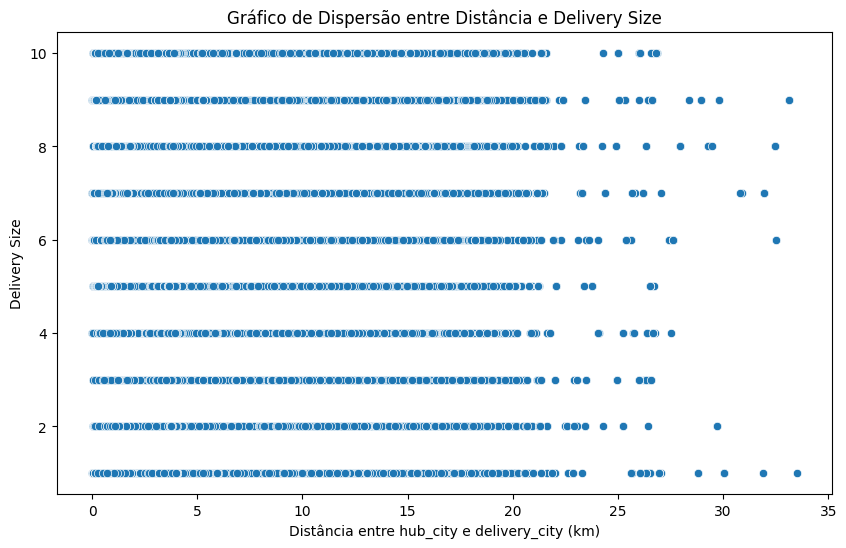

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Calcular a distância entre 'hub_city' e 'delivery_city' para cada linha
distances_hub_delivery = []

for index, row in df_df1.iterrows():
    hub_coords = (row['hub_lat'], row['hub_lng'])
    delivery_coords = (row['delivery_lat'], row['delivery_lng'])
    distance = geodesic(hub_coords, delivery_coords).km
    distances_hub_delivery.append(distance)

# Adicionar a coluna de distâncias ao DataFrame
df_df1['distance_hub_delivery'] = distances_hub_delivery

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_hub_delivery', y='delivery_size', data=df_df1)
plt.xlabel('Distância entre hub_city e delivery_city (km)')
plt.ylabel('Delivery Size')
plt.title('Gráfico de Dispersão entre Distância e Delivery Size')
plt.show()

In [37]:
# Filtrar as linhas onde 'region' é igual a 'df-0'
df_df2 = deliveries_df[deliveries_df['region'] == 'df-2']

# Resetar o índice do novo DataFrame, se necessário
df_df2.reset_index(drop=True, inplace=True)

# Exibir as primeiras linhas do novo DataFrame
df_df2.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


<ipython-input-38-d95eb7b80f75>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_df2['distance_hub_delivery'] = distances_hub_delivery


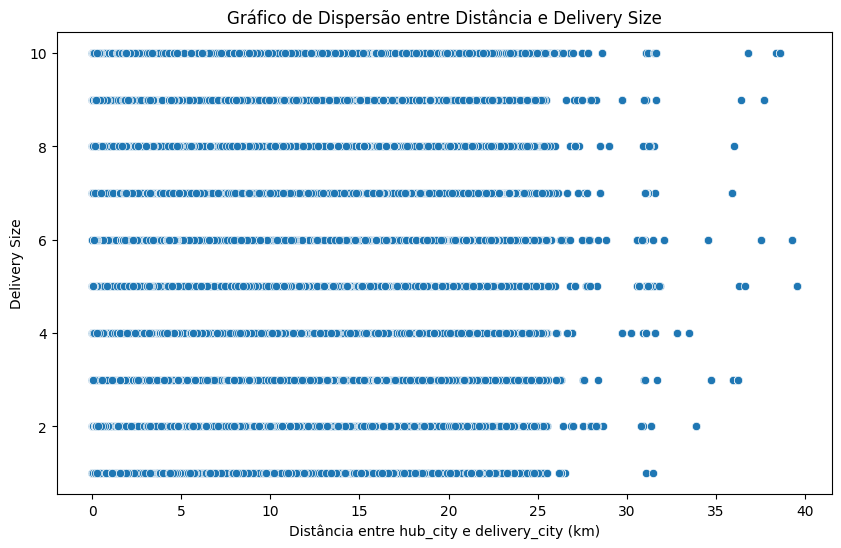

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Calcular a distância entre 'hub_city' e 'delivery_city' para cada linha
distances_hub_delivery = []

for index, row in df_df2.iterrows():
    hub_coords = (row['hub_lat'], row['hub_lng'])
    delivery_coords = (row['delivery_lat'], row['delivery_lng'])
    distance = geodesic(hub_coords, delivery_coords).km
    distances_hub_delivery.append(distance)

# Adicionar a coluna de distâncias ao DataFrame
df_df2['distance_hub_delivery'] = distances_hub_delivery

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_hub_delivery', y='delivery_size', data=df_df2)
plt.xlabel('Distância entre hub_city e delivery_city (km)')
plt.ylabel('Delivery Size')
plt.title('Gráfico de Dispersão entre Distância e Delivery Size')
plt.show()

In [39]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


<ipython-input-40-c90cc5d81efc>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
<ipython-input-40-c90cc5d81efc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")


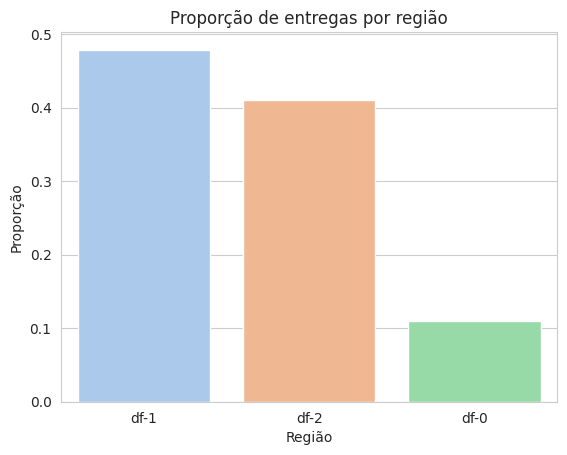

In [40]:
import seaborn as sns

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

 - **Insights**:

- The deliveries are properly assigned to their respective hubs.

- Hubs in regions 0 and 2 make deliveries to locations further away from the center and each other, which may result in longer delivery times and higher costs.

- The concentration of deliveries is significantly higher in hubs in regions 1 and 2, while it is relatively low in region 0. However, the vehicle capacity is uniform for all hubs, suggesting the possibility of reallocating vehicles to meet areas with higher traffic demand.

- We can observe through scatter plots that in df-0, the vehicles travel the longest distance and follow routes with the highest possible load, but with fewer deliveries than in region df-1.

- Regarding the issue of reverse geocoding, to comply with GDPR guidelines, it is essential for developers to use Nominatim responsibly and ensure that address and geolocation data are not misused or shared without proper consent.